In [1]:
%pip install prophet statsmodels scikit-learn keras tensorflow matplotlib pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 779.2 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 373.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 991.0/991.0 kB 474.3 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.express as px



In [4]:
# Convert to datetime and extract just the date
df['DateTime'] = pd.to_datetime(df['DateTime']).dt.date

# Keep the last record of each day
daily_df = df.groupby('DateTime').last().reset_index()

# Save the cleaned data
daily_df.to_csv('cleaned_stock_data.csv', index=False)

# Display the cleaned DataFrame and min/max values
print(daily_df)
print("Min value of BTCL stock:", daily_df.min())
print("Max value of BTCL stock:", daily_df.max())


        DateTime    BTCL
0     2020-04-23  158.45
1     2020-04-24  158.45
2     2020-04-27  158.45
3     2020-04-28  158.45
4     2020-04-29  158.45
...          ...     ...
1225  2025-04-21  570.00
1226  2025-04-22  570.00
1227  2025-04-23  570.00
1228  2025-04-24  570.00
1229  2025-04-25  570.00

[1230 rows x 2 columns]
Min value of BTCL stock: DateTime    2020-04-23
BTCL              40.0
dtype: object
Max value of BTCL stock: DateTime    2025-04-25
BTCL           1178.57
dtype: object


In [ ]:

# Convert DateTime column to datetime type 
daily_df['DateTime'] = pd.to_datetime(daily_df['DateTime'])

# Create interactive plot
fig = px.line(daily_df, 
              x='DateTime', 
              y='BTCL',
              title='BTCL Price Over Time',
              labels={'BTCL': 'Price (Ngultrum)', 'DateTime': 'Date'},
              template='plotly_white')

# Add customization
fig.update_layout(
    hovermode='y unified',  # Show hover data for all points on x-axis
    xaxis_title='Date',
    yaxis_title='BTCL Price (Ngultrum)',
    
    xaxis_rangeslider_visible=True  # Adds zoom slider at bottom
)

# Add hover data formatting
fig.update_traces(
    hovertemplate='<b>%{x|%Y-%m-%d}</b><br>Price: Nu.%{y:.2f}'
)

# Show the plot
fig.show()

18:26:07 - cmdstanpy - INFO - Chain [1] start processing
18:26:10 - cmdstanpy - INFO - Chain [1] done processing


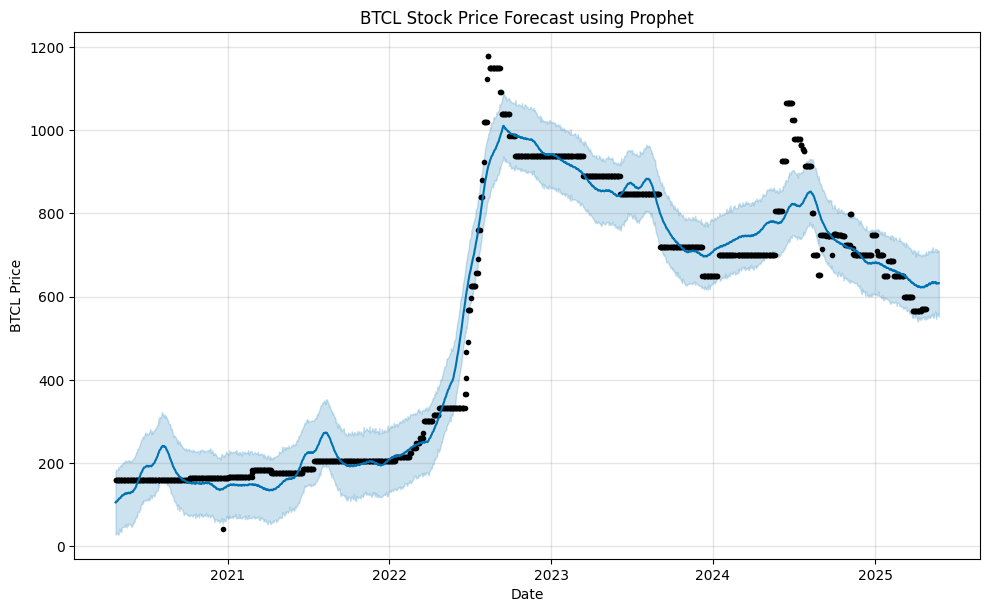

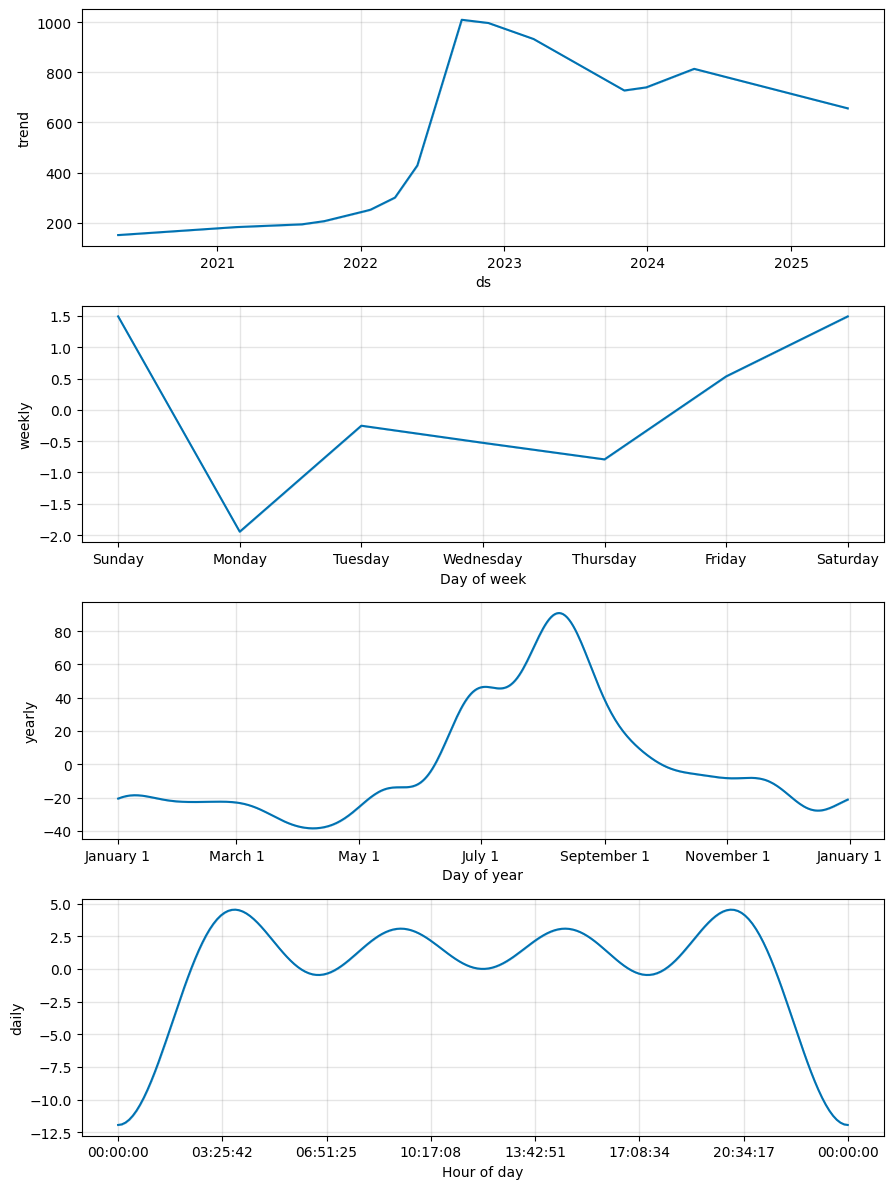

In [10]:
# Prophet expects columns 'ds' for date and 'y' for target
# Create a temporary DataFrame with correct column names for Prophet
prophet_df = pd.DataFrame()
prophet_df['ds'] = daily_df['DateTime']
prophet_df['y'] = daily_df['BTCL']

# Initialize and fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

# Create future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
plt.title("BTCL Stock Price Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("BTCL Price")
plt.grid(True)
plt.show()

# Optional: Plot forecast components (trend, seasonality)
fig2 = model.plot_components(forecast)
plt.show()

In [11]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))


             ds        yhat  yhat_lower  yhat_upper
1230 2025-04-26  626.954537  547.873694  708.381343
1231 2025-04-27  627.466529  545.126577  701.828122
1232 2025-04-28  624.577027  551.536182  703.020894
1233 2025-04-29  626.853597  552.904364  700.314346
1234 2025-04-30  627.188862  553.236963  702.043095
1235 2025-05-01  627.550401  547.488878  709.373700
1236 2025-05-02  629.511522  550.442979  709.647307
1237 2025-05-03  631.105750  554.966861  707.960620
1238 2025-05-04  631.731298  548.606288  709.726622
1239 2025-05-05  628.897097  549.828749  705.853541
1240 2025-05-06  631.166795  550.230337  706.756444
1241 2025-05-07  631.430196  552.342483  711.184893
1242 2025-05-08  631.653328  556.134650  706.580421
1243 2025-05-09  633.409391  557.637580  709.922676
1244 2025-05-10  634.733353  553.582185  712.096033
1245 2025-05-11  635.026527  559.496883  718.200179
1246 2025-05-12  631.802648  550.954200  706.708025
1247 2025-05-13  633.631882  548.829288  707.586746
1248 2025-05